In [1]:
import pickle

with open('URM_train_validation.pkl', 'rb') as f:
    URM_train_validation = pickle.load(f)
with open('URM_test.pkl', 'rb') as f:
    URM_test = pickle.load(f)

In [2]:
import pickle

with open('URM_train.pkl', 'rb') as f:
    URM_train = pickle.load(f)
with open('URM_validation.pkl', 'rb') as f:
    URM_validation = pickle.load(f)

In [ ]:
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender

ials = IALSRecommender(URM_train)
ials.fit(num_factors=198, epochs=240, confidence_scaling="log", alpha=0.7585204478683131, epsilon=0.012327186309393981, reg=0.14342697473521604)
ials.save_model("slim_models/", "IALS_train")

In [3]:
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender

ials = IALSRecommender(URM_train)
ials.load_model("slim_models/", "IALS_train")

IALSRecommender: URM Detected 422 ( 3.3%) users with no interactions.
IALSRecommender: URM Detected 329 ( 1.5%) items with no interactions.
IALSRecommender: Loading model from file 'slim_models/IALS_train'
IALSRecommender: Loading complete


In [ ]:
from Recommenders.Neural.MultVAERecommender import MultVAERecommender_OptimizerMask
final = MultVAERecommender_OptimizerMask(URM_train_validation)
epochs = 300
final.fit(epochs=epochs, learning_rate=0.0002229220517428562, l2_reg=1.7199457884691567e-05, dropout=0.5397666797136971, total_anneal_steps=134713, anneal_cap=0.20025495518554443,batch_size=512,encoding_size=460,next_layer_size_multiplier=10,max_n_hidden_layers=4, max_parameters=3000000000.0)

mv = final
mv.save_model("slim_models/", "MultVAE_train_300")

In [4]:
from Recommenders.Neural.MultVAERecommender import MultVAERecommender_OptimizerMask
mv = MultVAERecommender_OptimizerMask(URM_train)
mv.load_model("slim_models/", "MultVAE_train_300")

MultVAERecommender: URM Detected 422 ( 3.3%) users with no interactions.
MultVAERecommender: URM Detected 329 ( 1.5%) items with no interactions.
MultVAERecommender: Loading model from file 'slim_models/MultVAE_train_300'


2024-01-05 12:00:55.228921: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-01-05 12:00:55.228941: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-05 12:00:55.228945: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-05 12:00:55.229247: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-05 12:00:55.229510: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-01-05 12:00:55.337114: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-01-05 12:00:55.350326: I tensorflow/core/gra

INFO:tensorflow:Restoring parameters from slim_models/MultVAE_train_300/.session/session
MultVAERecommender: Loading complete


In [ ]:
from Recommenders.Neural.MultVAERecommender import MultVAERecommender_OptimizerMask
final = MultVAERecommender_OptimizerMask(URM_train_validation)
final.load_model("slim_models/", "MultVAE_train_validation_300")
mv = final

In [5]:
from Hybrid import *
from Recommenders.SLIM.SLIMElasticNetRecommender import *
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
## SLIM
slim = SLIMElasticNetRecommender(URM_train)
slim.fit(topK=8894, l1_ratio=0.05565733019999427, alpha=0.0012979360257937668)#, workers=7)
## RP3BETA
rp3beta = RP3betaRecommender(URM_train)
rp3beta.fit(alpha=0.20026352123406477, beta=0.15999879728761354, topK=32)
## USER KNN
userknn = UserKNNCFRecommender(URM_train)
userknn.fit(topK=469, shrink=38, similarity='asymmetric', normalize=True,
                                       feature_weighting='TF-IDF', asymmetric_alpha=0.40077406933762383)
## ITEM KNN
itemknn = ItemKNNCFRecommender(URM_train)
itemknn.fit(topK=31, shrink=435, similarity='tversky', normalize=True,
                                       feature_weighting='BM25', tversky_alpha=0.17113169506422393, tversky_beta=0.5684024974085575)
## EASE_R
ease_r = EASE_R_Recommender(URM_train)
ease_r.fit(topK=24, l2_norm=37.54323189430143)

## PURESVD
puresvd = PureSVDRecommender(URM_train)
puresvd.fit(num_factors=69)

## P3ALPHA
p3alpha = P3alphaRecommender(URM_train)
p3alpha.fit(topK=76, alpha=0.377201600381895, normalize_similarity=True)

## HYBRIDS

knn = TwoScoresHybridRecommender(URM_train, userknn, itemknn)
knn.fit(alpha=0.022195783788315104)

h_li = LinearHybridRecommender(URM_train, [slim, rp3beta, knn, ease_r])
h_li.fit(alphas=[0.8857667100747117, 0.6379807942443021, 0.0690929184825888, 0.11953478623354052])
h_hi = TwoScoresHybridRecommender(URM_train, slim, rp3beta)
h_hi.fit(alpha=0.6201320790279279)

SLIMElasticNetRecommender: URM Detected 422 ( 3.3%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 329 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 4.43 min. Items per second: 83.59
RP3betaRecommender: URM Detected 422 ( 3.3%) users with no interactions.
RP3betaRecommender: URM Detected 329 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 7947.71 column/sec. Elapsed time 2.80 sec
UserKNNCFRecommender: URM Detected 422 ( 3.3%) users with no interactions.
UserKNNCFRecommender: URM Detected 329 ( 1.5%) items with no interactions.
Similarity column 12638 (100.0%), 11818.55 column/sec. Elapsed time 1.07 sec
ItemKNNCFRecommender: URM Detected 422 ( 3.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 329 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 10894.10 column/sec. Elapsed time 2.04 sec
EASE_R_Recommender: URM Detected 422 ( 3.3%) users with

In [7]:
recommenders_train = {
                #"Hybrid": hybrid,
                "SLIM": slim, 
                "RP3beta": rp3beta, 
                "UserKNN": userknn, 
                "ItemKNN": itemknn, 
                "EASE_R": ease_r,
                #"PureSVD": puresvd, 
                "P3alpha": p3alpha,
                "MULTVAE": mv,
                "IALS": ials,
                #"KNN": knn, 
                #"H_LI": h_li, 
                #"H_HI": h_hi
                }
h_hi_train = h_hi

In [8]:
from Hybrid import *
from Recommenders.SLIM.SLIMElasticNetRecommender import *
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
## SLIM
slim = SLIMElasticNetRecommender(URM_train_validation)
slim.fit(topK=8894, l1_ratio=0.05565733019999427, alpha=0.0012979360257937668)#, workers=7)
## RP3BETA
rp3beta = RP3betaRecommender(URM_train_validation)
rp3beta.fit(alpha=0.20026352123406477, beta=0.15999879728761354, topK=32)
## USER KNN
userknn = UserKNNCFRecommender(URM_train_validation)
userknn.fit(topK=469, shrink=38, similarity='asymmetric', normalize=True,
                                       feature_weighting='TF-IDF', asymmetric_alpha=0.40077406933762383)
## ITEM KNN
itemknn = ItemKNNCFRecommender(URM_train_validation)
itemknn.fit(topK=31, shrink=435, similarity='tversky', normalize=True,
                                       feature_weighting='BM25', tversky_alpha=0.17113169506422393, tversky_beta=0.5684024974085575)
## EASE_R
ease_r = EASE_R_Recommender(URM_train_validation)
ease_r.fit(topK=24, l2_norm=37.54323189430143)

## PURESVD
puresvd = PureSVDRecommender(URM_train_validation)
puresvd.fit(num_factors=69)

## P3ALPHA
p3alpha = P3alphaRecommender(URM_train_validation)
p3alpha.fit(topK=76, alpha=0.377201600381895, normalize_similarity=True)

## HYBRIDS

knn = TwoScoresHybridRecommender(URM_train_validation, userknn, itemknn)
knn.fit(alpha=0.022195783788315104)

h_li = LinearHybridRecommender(URM_train_validation, [slim, rp3beta, knn, ease_r])
h_li.fit(alphas=[0.8857667100747117, 0.6379807942443021, 0.0690929184825888, 0.11953478623354052])
h_hi = TwoScoresHybridRecommender(URM_train_validation, slim, rp3beta)
h_hi.fit(alpha=0.6201320790279279)

SLIMElasticNetRecommender: URM Detected 205 ( 1.6%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 109 ( 0.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 4.56 min. Items per second: 81.28
RP3betaRecommender: URM Detected 205 ( 1.6%) users with no interactions.
RP3betaRecommender: URM Detected 109 ( 0.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 7296.49 column/sec. Elapsed time 3.05 sec
UserKNNCFRecommender: URM Detected 205 ( 1.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 109 ( 0.5%) items with no interactions.
Similarity column 12638 (100.0%), 10145.61 column/sec. Elapsed time 1.25 sec
ItemKNNCFRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 109 ( 0.5%) items with no interactions.
Similarity column 22222 (100.0%), 10178.04 column/sec. Elapsed time 2.18 sec
EASE_R_Recommender: URM Detected 205 ( 1.6%) users with

In [9]:
recommenders_t_val = {
                #"Hybrid": hybrid,
                "SLIM": slim, 
                "RP3beta": rp3beta, 
                "UserKNN": userknn, 
                "ItemKNN": itemknn, 
                "EASE_R": ease_r,
                #"PureSVD": puresvd, 
                "P3alpha": p3alpha,
                "MULTVAE": mv,
                "IALS": ials,
                #"KNN": knn, 
                #"H_LI": h_li, 
                #"H_HI": h_hi
                }
h_hi_t_val = h_hi

In [61]:
recommenders_train_two = recommenders_train.copy()
recommenders_train_two.pop("KNN")
recommenders_train_two.pop("H_LI")
recommenders_train_two.pop("H_HI")
recommenders_train_two.pop("Hybrid")

In [32]:
from Recommenders.XGBoostEnsemble import XgBoostEnsembler
XGBoostRecommender = XgBoostEnsembler(URM_train, URM_val=URM_validation, recommenders=recommenders_train, recommenders_generate_data=get_dict(recommenders_train), internal_cutoff_xgboost=11)

XgBoostEnsembler: URM Detected 422 ( 3.3%) users with no interactions.
XgBoostEnsembler: URM Detected 329 ( 1.5%) items with no interactions.


In [40]:
from Recommenders.XGBoostEnsemble import XgBoostEnsembler
XGBoostRecommender = XgBoostEnsembler(URM_train, URM_val=URM_validation, recommenders=recommenders_train_two, recommenders_generate_data=get_dict(recommenders_train_two), internal_cutoff_xgboost=20)

XgBoostEnsembler: URM Detected 422 ( 3.3%) users with no interactions.
XgBoostEnsembler: URM Detected 329 ( 1.5%) items with no interactions.


Creating training dataframe...
Populating training dataframe with labels...
Percentage of positive samples: 4.20%
Populating training dataframe with item scores...


100%|██████████| 9/9 [00:24<00:00,  2.72s/it]


MSE: 7.12


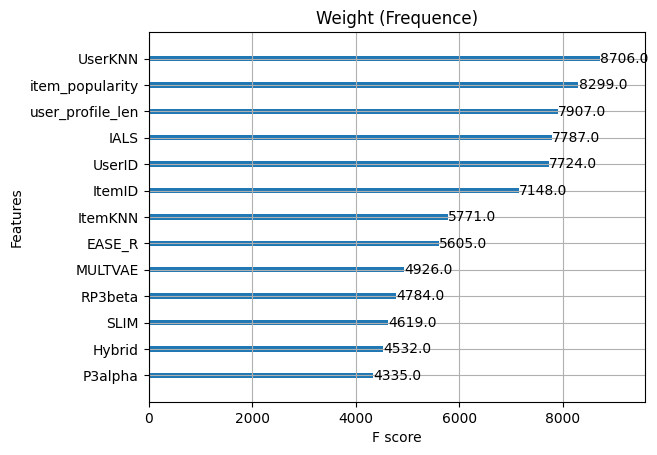

In [41]:
xgb_ranker_params = {
    "n_estimators": 50,
    "learning_rate": 1e-1,
    "reg_alpha": 1e-1,
    "reg_lambda": 1e-1,
    "max_depth": 20,
    "max_leaves": 0,
    "grow_policy": "depthwise",
    "objective": "rank:pairwise",
    "booster": "gbtree",
}
XGBoostRecommender.fit(xgb_ranker_params=xgb_ranker_params, plot=True)

In [ ]:
from joblib import dump

# Save the dictionary
dump(recommenders_train, 'recommenders_train.joblib')
dump(recommenders_t_val, 'recommenders_t_val.joblib')

In [60]:
recommenders_t_val_two = recommenders_t_val.copy()
recommenders_t_val_two.pop("KNN")
recommenders_t_val_two.pop("H_LI")
recommenders_t_val_two.pop("H_HI")
recommenders_t_val_two.pop("Hybrid")

In [35]:
XGBoostRecommender.recommenders = recommenders_t_val
XGBoostRecommender.recommenders_generate_data = get_dict(recommenders_t_val)

In [43]:
XGBoostRecommender.recommenders = recommenders_t_val_two
XGBoostRecommender.recommenders_generate_data = get_dict(recommenders_t_val_two)

In [11]:
from Evaluation.Evaluator import EvaluatorHoldout
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2203 (17.4%) Users that have less than 1 test interactions


In [27]:
evaluator_test.evaluateRecommender(h_hi_t_val)

EvaluatorHoldout: Processed 10435 (100.0%) in 4.43 sec. Users per second: 2354


(       PRECISION PRECISION_RECALL_MIN_DEN    RECALL       MAP MAP_MIN_DEN  \
 cutoff                                                                      
 10      0.099425                 0.169137  0.141611  0.051901    0.086837   
 
              MRR      NDCG        F1  HIT_RATE ARHR_ALL_HITS  ...  \
 cutoff                                                        ...   
 10      0.284584  0.156265  0.116826  0.533014      0.378869  ...   
 
        COVERAGE_USER COVERAGE_USER_HIT USERS_IN_GT DIVERSITY_GINI  \
 cutoff                                                              
 10          0.825684          0.440101    0.825684       0.067983   
 
        SHANNON_ENTROPY RATIO_DIVERSITY_HERFINDAHL RATIO_DIVERSITY_GINI  \
 cutoff                                                                   
 10           10.495531                   0.998292             0.195025   
 
        RATIO_SHANNON_ENTROPY RATIO_AVERAGE_POPULARITY RATIO_NOVELTY  
 cutoff                                   

In [ ]:
evaluator_test.evaluateRecommender(XGBoostRecommender)

In [17]:
import optuna as op
from Recommenders.XGBoostEnsemble import XgBoostEnsembler
rgd = {
    "H_HI" : h_hi_train,
}
rgd_t_val = {
    "H_HI" : h_hi_t_val,
}
xgb_ranker_params = {
    "n_estimators": 50,
    "learning_rate": 1e-1,
    "reg_alpha": 1e-1,
    "reg_lambda": 1e-1,
    "max_depth": 20,
    "max_leaves": 0,
    "grow_policy": "depthwise",
    "objective": "rank:pairwise",
    "booster": "gbtree",
}
def objective(trial):
    param = {
            "verbosity": 0,
            "objective": trial.suggest_categorical("objective", ["rank:pairwise", "rank:ndcg", "rank:map"]),
            "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
            "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1.0, log=True),
            "eval_metric": "auc",
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear"]),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
        }
    
    if param["booster"] == "gbtree":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 25)
        param["eta"] = trial.suggest_float("eta", 1e-4, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-4, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
        param["max_delta_step"] = trial.suggest_int("max_delta_step", 1, 20)
        

    
    xgb = XgBoostEnsembler(URM_train, URM_val=URM_validation, recommenders=recommenders_train, recommenders_generate_data=rgd, internal_cutoff_xgboost=trial.suggest_int("internal_cutoff_xgboost", 10, 36))
    xgb.fit(xgb_ranker_params=param, prepare_training_df=True, plot=False)
    xgb.recommenders = recommenders_t_val
    xgb.recommenders_generate_data = rgd_t_val
    
    result, _ = evaluator_test.evaluateRecommender(xgb)
    MAP_result = result["MAP"].item()
    return MAP_result

In [33]:
import optuna as op
from Recommenders.XGBoostEnsemble import XgBoostEnsembler
rgd = {
    "H_HI" : h_hi_train,
}
rgd_t_val = {
    "H_HI" : h_hi_t_val,
}
xgb_ranker_params = {
    "n_estimators": 50,
    "learning_rate": 1e-1,
    "reg_alpha": 1e-1,
    "reg_lambda": 1e-1,
    "max_depth": 20,
    "max_leaves": 0,
    "grow_policy": "depthwise",
    "objective": "rank:pairwise",
    "booster": "gbtree",
}
def objective(trial):
    param = {
            "verbosity": 0,
            "objective": trial.suggest_categorical("objective", ["rank:pairwise", "rank:ndcg", "rank:map"]),
            "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
            "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1.0, log=True),
            "eval_metric": "auc",
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear"]),
            "lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0, log=True),
            "alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
        }
    
    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 25)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
        param["max_delta_step"] = trial.suggest_int("max_delta_step", 1, 20)
    if param['booster'] == 'dart':
        # Add booster-specific parameters for 'dart'
        param['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        param['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        param['rate_drop'] = trial.suggest_float('rate_drop', 1e-8, 1.0, log=True)
        param['skip_drop'] = trial.suggest_float('skip_drop', 1e-8, 1.0, log=True) 

    
    xgb = XgBoostEnsembler(URM_train, URM_val=URM_validation, recommenders=recommenders_train, recommenders_generate_data=rgd, internal_cutoff_xgboost=trial.suggest_int("internal_cutoff_xgboost", 10, 36))
    xgb.fit(xgb_ranker_params=param, prepare_training_df=True, plot=False)
    xgb.recommenders = recommenders_t_val
    xgb.recommenders_generate_data = rgd_t_val
    
    result, _ = evaluator_test.evaluateRecommender(xgb)
    MAP_result = result["MAP"].item()
    return MAP_result

In [ ]:
study_name = "XGB-HI-2-study-test"  # Unique identifier of the study.
storage_name = "sqlite:///db.db"
study = op.create_study(study_name=study_name, storage=storage_name, direction="maximize",load_if_exists=True)
study.optimize(objective, n_trials=20)
# beat 0.0519020 

In [42]:
study.best_params

{'objective': 'rank:pairwise',
 'n_estimators': 798,
 'learning_rate': 0.005475198763293265,
 'booster': 'gblinear',
 'reg_lambda': 1.5579294735565626e-08,
 'reg_alpha': 9.59987912675069e-07,
 'internal_cutoff_xgboost': 10}

In [45]:
import optuna as op
from Recommenders.XGBoostEnsemble import XgBoostEnsembler

knn_train = TwoScoresHybridRecommender(URM_train, recommenders_train["UserKNN"], recommenders_train["ItemKNN"])
knn_train.fit(alpha=0.022195783788315104)

h_li_train = LinearHybridRecommender(URM_train, [recommenders_train["SLIM"], recommenders_train["RP3beta"], knn_train, recommenders_train["EASE_R"]])
h_li_train.fit(alphas=[0.8857667100747117, 0.6379807942443021, 0.0690929184825888, 0.11953478623354052])

knn_t_val = TwoScoresHybridRecommender(URM_train, recommenders_t_val["UserKNN"], recommenders_t_val["ItemKNN"])
knn_t_val.fit(alpha=0.022195783788315104)

h_li_t_val = LinearHybridRecommender(URM_train_validation, [recommenders_t_val["SLIM"], recommenders_t_val["RP3beta"], knn_t_val, recommenders_t_val["EASE_R"]])
h_li_t_val.fit(alphas=[0.8857667100747117, 0.6379807942443021, 0.0690929184825888, 0.11953478623354052])

rgd = {
    "H_LI" : h_li_train,
}
rgd_t_val = {
    "H_LI" : h_li_t_val,
}

def objective(trial):
    param = {
            "verbosity": 0,
            "objective": trial.suggest_categorical("objective", ["rank:pairwise", "rank:ndcg", "rank:map"]),
            "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
            "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1.0, log=True),
            "eval_metric": "auc",
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear"]),
            "lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0, log=True),
            "alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
        }
    
    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 25)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
        param["max_delta_step"] = trial.suggest_int("max_delta_step", 1, 20)
    if param['booster'] == 'dart':
        # Add booster-specific parameters for 'dart'
        param['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        param['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        param['rate_drop'] = trial.suggest_float('rate_drop', 1e-8, 1.0, log=True)
        param['skip_drop'] = trial.suggest_float('skip_drop', 1e-8, 1.0, log=True) 

    
    xgb = XgBoostEnsembler(URM_train, URM_val=URM_validation, recommenders=recommenders_train, recommenders_generate_data=rgd, internal_cutoff_xgboost=trial.suggest_int("internal_cutoff_xgboost", 10, 36))
    xgb.fit(xgb_ranker_params=param, prepare_training_df=True, plot=False)
    xgb.recommenders = recommenders_t_val
    xgb.recommenders_generate_data = rgd_t_val
    
    result, _ = evaluator_test.evaluateRecommender(xgb)
    MAP_result = result["MAP"].item()
    return MAP_result

UserKNNCFItemKNNCFTwoScoresHybridRecommender: URM Detected 422 ( 3.3%) users with no interactions.
UserKNNCFItemKNNCFTwoScoresHybridRecommender: URM Detected 329 ( 1.5%) items with no interactions.
SLIMElasticNetRP3betaUserKNNCFItemKNNCFTwoScoresHybridEASE_R_LinearHybridRecommender: URM Detected 422 ( 3.3%) users with no interactions.
SLIMElasticNetRP3betaUserKNNCFItemKNNCFTwoScoresHybridEASE_R_LinearHybridRecommender: URM Detected 329 ( 1.5%) items with no interactions.
UserKNNCFItemKNNCFTwoScoresHybridRecommender: URM Detected 422 ( 3.3%) users with no interactions.
UserKNNCFItemKNNCFTwoScoresHybridRecommender: URM Detected 329 ( 1.5%) items with no interactions.
SLIMElasticNetRP3betaUserKNNCFItemKNNCFTwoScoresHybridEASE_R_LinearHybridRecommender: URM Detected 205 ( 1.6%) users with no interactions.
SLIMElasticNetRP3betaUserKNNCFItemKNNCFTwoScoresHybridEASE_R_LinearHybridRecommender: URM Detected 109 ( 0.5%) items with no interactions.


In [ ]:
study_name = "XGB-LI-study-test"  # Unique identifier of the study.
storage_name = "sqlite:///db.db"
study = op.create_study(study_name=study_name, storage=storage_name, direction="maximize",load_if_exists=True)
study.optimize(objective, n_trials=20)
# beat 0.0520373 

In [46]:
evaluator_test.evaluateRecommender(h_li_t_val)

EvaluatorHoldout: Processed 10435 (100.0%) in 9.36 sec. Users per second: 1114


(       PRECISION PRECISION_RECALL_MIN_DEN    RECALL       MAP MAP_MIN_DEN  \
 cutoff                                                                      
 10       0.10024                 0.172969  0.145334  0.052037    0.087769   
 
              MRR      NDCG        F1  HIT_RATE ARHR_ALL_HITS  ...  \
 cutoff                                                        ...   
 10      0.285611  0.158053  0.118647  0.538955      0.380213  ...   
 
        COVERAGE_USER COVERAGE_USER_HIT USERS_IN_GT DIVERSITY_GINI  \
 cutoff                                                              
 10          0.825684          0.445007    0.825684       0.058394   
 
        SHANNON_ENTROPY RATIO_DIVERSITY_HERFINDAHL RATIO_DIVERSITY_GINI  \
 cutoff                                                                   
 10           10.187322                   0.997481             0.167517   
 
        RATIO_SHANNON_ENTROPY RATIO_AVERAGE_POPULARITY RATIO_NOVELTY  
 cutoff                                   

In [50]:
import optuna as op
from Recommenders.XGBoostEnsemble import XgBoostEnsembler

knn_train = TwoScoresHybridRecommender(URM_train, recommenders_train["UserKNN"], recommenders_train["ItemKNN"])
knn_train.fit(alpha=0.022195783788315104)

lint_train = ScoresHybridRecommender(URM_train_validation, knn_train, recommenders_train["MULTVAE"], recommenders_train["IALS"])
lint_train.fit(alpha=0.7509279131476281,beta=0.028318614437090585)


knn_t_val = TwoScoresHybridRecommender(URM_train, recommenders_t_val["UserKNN"], recommenders_t_val["ItemKNN"])
knn_t_val.fit(alpha=0.022195783788315104)

lint_t_val = ScoresHybridRecommender(URM_train_validation, knn_t_val, recommenders_t_val["MULTVAE"], recommenders_t_val["IALS"])
lint_t_val.fit(alpha=0.7509279131476281,beta=0.028318614437090585)

rgd = {
    "LINT" : lint_train,
}
rgd_t_val = {
    "LINT" : lint_t_val,
}

def objective(trial):
    param = {
            "verbosity": 0,
            "objective": trial.suggest_categorical("objective", ["rank:pairwise", "rank:ndcg", "rank:map"]),
            "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
            "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1.0, log=True),
            "eval_metric": "auc",
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear"]),
            "lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0, log=True),
            "alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
        }
    
    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 25)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
        param["max_delta_step"] = trial.suggest_int("max_delta_step", 1, 20)
    if param['booster'] == 'dart':
        # Add booster-specific parameters for 'dart'
        param['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        param['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        param['rate_drop'] = trial.suggest_float('rate_drop', 1e-8, 1.0, log=True)
        param['skip_drop'] = trial.suggest_float('skip_drop', 1e-8, 1.0, log=True) 

    
    xgb = XgBoostEnsembler(URM_train, URM_val=URM_validation, recommenders=recommenders_train, recommenders_generate_data=rgd, internal_cutoff_xgboost=trial.suggest_int("internal_cutoff_xgboost", 10, 36))
    xgb.fit(xgb_ranker_params=param, prepare_training_df=True, plot=False)
    xgb.recommenders = recommenders_t_val
    xgb.recommenders_generate_data = rgd_t_val
    
    result, _ = evaluator_test.evaluateRecommender(xgb)
    MAP_result = result["MAP"].item()
    return MAP_result

UserKNNCFItemKNNCFTwoScoresHybridRecommender: URM Detected 422 ( 3.3%) users with no interactions.
UserKNNCFItemKNNCFTwoScoresHybridRecommender: URM Detected 329 ( 1.5%) items with no interactions.
UserKNNCFItemKNNCFTwoScoresHybridMultVAEIALSScoresHybridRecommender: URM Detected 205 ( 1.6%) users with no interactions.
UserKNNCFItemKNNCFTwoScoresHybridMultVAEIALSScoresHybridRecommender: URM Detected 109 ( 0.5%) items with no interactions.
UserKNNCFItemKNNCFTwoScoresHybridRecommender: URM Detected 422 ( 3.3%) users with no interactions.
UserKNNCFItemKNNCFTwoScoresHybridRecommender: URM Detected 329 ( 1.5%) items with no interactions.
UserKNNCFItemKNNCFTwoScoresHybridMultVAEIALSScoresHybridRecommender: URM Detected 205 ( 1.6%) users with no interactions.
UserKNNCFItemKNNCFTwoScoresHybridMultVAEIALSScoresHybridRecommender: URM Detected 109 ( 0.5%) items with no interactions.


In [53]:
study_name = "XGB-1-study-test"  # Unique identifier of the study.
storage_name = "sqlite:///db.db"
study = op.create_study(study_name=study_name, storage=storage_name, direction="maximize",load_if_exists=True)
study.optimize(objective, n_trials=10)
# 216

[I 2024-01-06 00:34:32,479] Using an existing study with name 'XGB-1-study-test' instead of creating a new one.


XgBoostEnsembler: URM Detected 422 ( 3.3%) users with no interactions.
XgBoostEnsembler: URM Detected 329 ( 1.5%) items with no interactions.
Creating training dataframe...
Populating training dataframe with labels...
Percentage of positive samples: 0.00%
Populating training dataframe with item scores...


100%|██████████| 8/8 [00:11<00:00,  1.42s/it]


MSE: 0.00
Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 4979.99it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5122.85it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5144.73it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5192.98it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5157.80it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5177.19it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5089.16it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5101.26it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5103.71it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5186.91it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 435/435 [00:00<00:00, 5217.15it/s]


EvaluatorHoldout: Processed 10435 (100.0%) in 18.20 sec. Users per second: 573


[I 2024-01-06 00:35:24,747] Trial 7 finished with value: 0.022376936591598826 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 570, 'learning_rate': 1.776594627563913e-07, 'booster': 'gbtree', 'reg_lambda': 3.9774433098020286e-08, 'reg_alpha': 0.00035903134943214527, 'max_depth': 23, 'eta': 0.5201779822333412, 'gamma': 1.9679939915272907e-06, 'grow_policy': 'lossguide', 'max_delta_step': 11, 'internal_cutoff_xgboost': 25}. Best is trial 4 with value: 0.03500464325644021.


XgBoostEnsembler: URM Detected 422 ( 3.3%) users with no interactions.
XgBoostEnsembler: URM Detected 329 ( 1.5%) items with no interactions.
Creating training dataframe...
Populating training dataframe with labels...
Percentage of positive samples: 0.00%
Populating training dataframe with item scores...


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


MSE: 0.00
Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5121.22it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5006.33it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 4597.97it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5137.11it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5203.70it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5208.66it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5254.66it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5249.07it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5173.71it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5176.90it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 435/435 [00:00<00:00, 5490.12it/s]


EvaluatorHoldout: Processed 10435 (100.0%) in 18.71 sec. Users per second: 558


[I 2024-01-06 00:36:12,587] Trial 8 finished with value: 0.02717441303306192 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 623, 'learning_rate': 6.908847178255325e-06, 'booster': 'gbtree', 'reg_lambda': 0.015112507572926146, 'reg_alpha': 1.1751651136621999e-05, 'max_depth': 24, 'eta': 0.04563853998901812, 'gamma': 0.39587303647972977, 'grow_policy': 'depthwise', 'max_delta_step': 5, 'internal_cutoff_xgboost': 18}. Best is trial 4 with value: 0.03500464325644021.


XgBoostEnsembler: URM Detected 422 ( 3.3%) users with no interactions.
XgBoostEnsembler: URM Detected 329 ( 1.5%) items with no interactions.
Creating training dataframe...
Populating training dataframe with labels...
Percentage of positive samples: 0.00%
Populating training dataframe with item scores...


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


MSE: 0.00
Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 4986.08it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5045.26it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5046.33it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5080.14it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5017.87it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5084.14it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5120.28it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5190.71it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5230.27it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5135.87it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 435/435 [00:00<00:00, 5481.75it/s]


EvaluatorHoldout: Processed 10435 (100.0%) in 18.07 sec. Users per second: 577


[I 2024-01-06 00:36:58,328] Trial 9 finished with value: 0.022376936591598826 and parameters: {'objective': 'rank:map', 'n_estimators': 923, 'learning_rate': 2.870376106138228e-07, 'booster': 'gbtree', 'reg_lambda': 8.34848804584594e-08, 'reg_alpha': 0.01652295724940925, 'max_depth': 6, 'eta': 0.00335240632324173, 'gamma': 5.7520082479250105e-08, 'grow_policy': 'lossguide', 'max_delta_step': 14, 'internal_cutoff_xgboost': 25}. Best is trial 4 with value: 0.03500464325644021.


XgBoostEnsembler: URM Detected 422 ( 3.3%) users with no interactions.
XgBoostEnsembler: URM Detected 329 ( 1.5%) items with no interactions.
Creating training dataframe...
Populating training dataframe with labels...
Percentage of positive samples: 0.00%
Populating training dataframe with item scores...


100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


MSE: nan
Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 4850.20it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 4958.33it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 4967.61it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 4917.31it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 4981.28it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5030.94it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 4905.54it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5022.73it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 4788.17it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 4967.37it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 435/435 [00:00<00:00, 5341.75it/s]


EvaluatorHoldout: Processed 10435 (100.0%) in 17.42 sec. Users per second: 599


[I 2024-01-06 00:37:43,734] Trial 10 finished with value: 4.4732699021151345e-05 and parameters: {'objective': 'rank:map', 'n_estimators': 691, 'learning_rate': 4.4729125735151455e-05, 'booster': 'gblinear', 'reg_lambda': 0.007319825019649405, 'reg_alpha': 0.0012264950117575545, 'internal_cutoff_xgboost': 36}. Best is trial 4 with value: 0.03500464325644021.


XgBoostEnsembler: URM Detected 422 ( 3.3%) users with no interactions.
XgBoostEnsembler: URM Detected 329 ( 1.5%) items with no interactions.
Creating training dataframe...
Populating training dataframe with labels...
Percentage of positive samples: 0.00%
Populating training dataframe with item scores...


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


MSE: 0.00
Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 4972.23it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 4979.41it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5028.41it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5090.72it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5013.89it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 4995.11it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 4864.86it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5007.53it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 4981.25it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 4784.30it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 435/435 [00:00<00:00, 5263.54it/s]


EvaluatorHoldout: Processed 10435 (100.0%) in 18.11 sec. Users per second: 576


[I 2024-01-06 00:38:26,300] Trial 11 finished with value: 0.02008761722226033 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 330, 'learning_rate': 0.027877696315889162, 'booster': 'gbtree', 'reg_lambda': 0.9012127788559451, 'reg_alpha': 2.0989445407508798e-08, 'max_depth': 9, 'eta': 2.17790856306768e-06, 'gamma': 0.0005491548043793969, 'grow_policy': 'lossguide', 'max_delta_step': 20, 'internal_cutoff_xgboost': 32}. Best is trial 4 with value: 0.03500464325644021.


XgBoostEnsembler: URM Detected 422 ( 3.3%) users with no interactions.
XgBoostEnsembler: URM Detected 329 ( 1.5%) items with no interactions.
Creating training dataframe...
Populating training dataframe with labels...
Percentage of positive samples: 0.00%
Populating training dataframe with item scores...


100%|██████████| 8/8 [00:17<00:00,  2.23s/it]


MSE: 0.00
Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 4263.05it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5057.99it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 4714.53it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5067.91it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 4935.42it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 5179.90it/s]


Creating training dataframe...
Populating training dataframe with item scores...


100%|██████████| 1000/1000 [00:00<00:00, 4875.56it/s]


Creating training dataframe...


[W 2024-01-06 00:39:23,925] Trial 12 failed with parameters: {'objective': 'rank:ndcg', 'n_estimators': 989, 'learning_rate': 1.1387078751933327e-08, 'booster': 'gbtree', 'reg_lambda': 8.422956862638953e-06, 'reg_alpha': 7.634545441063569e-07, 'max_depth': 16, 'eta': 3.0071234775417854e-08, 'gamma': 1.0556202032026349e-08, 'grow_policy': 'depthwise', 'max_delta_step': 19, 'internal_cutoff_xgboost': 11} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/alessandro/RecSys-2023-polimi/venv/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/l3/n3yjvx_d2g9dy0ztkyft2th40000gn/T/ipykernel_2689/3456329998.py", line 55, in objective
    result, _ = evaluator_test.evaluateRecommender(xgb)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/alessandro/RecSys-2023-polimi/Evaluation/Evaluator.py", line 276, in e

KeyboardInterrupt: 

In [52]:
evaluator_test.evaluateRecommender(lint_t_val)

EvaluatorHoldout: Processed 10435 (100.0%) in 9.09 sec. Users per second: 1149


(       PRECISION PRECISION_RECALL_MIN_DEN    RECALL       MAP MAP_MIN_DEN  \
 cutoff                                                                      
 10      0.088241                  0.15575  0.131781  0.044584    0.076553   
 
              MRR      NDCG        F1 HIT_RATE ARHR_ALL_HITS  ...  \
 cutoff                                                       ...   
 10      0.259631  0.140746  0.105703  0.50666       0.33643  ...   
 
        COVERAGE_USER COVERAGE_USER_HIT USERS_IN_GT DIVERSITY_GINI  \
 cutoff                                                              
 10          0.825684          0.418342    0.825684       0.024596   
 
        SHANNON_ENTROPY RATIO_DIVERSITY_HERFINDAHL RATIO_DIVERSITY_GINI  \
 cutoff                                                                   
 10            8.750562                   0.991364              0.07056   
 
        RATIO_SHANNON_ENTROPY RATIO_AVERAGE_POPULARITY RATIO_NOVELTY  
 cutoff                                      

XgBoostEnsembler: URM Detected 205 ( 1.6%) users with no interactions.
XgBoostEnsembler: URM Detected 109 ( 0.5%) items with no interactions.
Creating training dataframe...
Populating training dataframe with labels...
Percentage of positive samples: 8.21%
Populating training dataframe with item scores...


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


MSE: 0.36


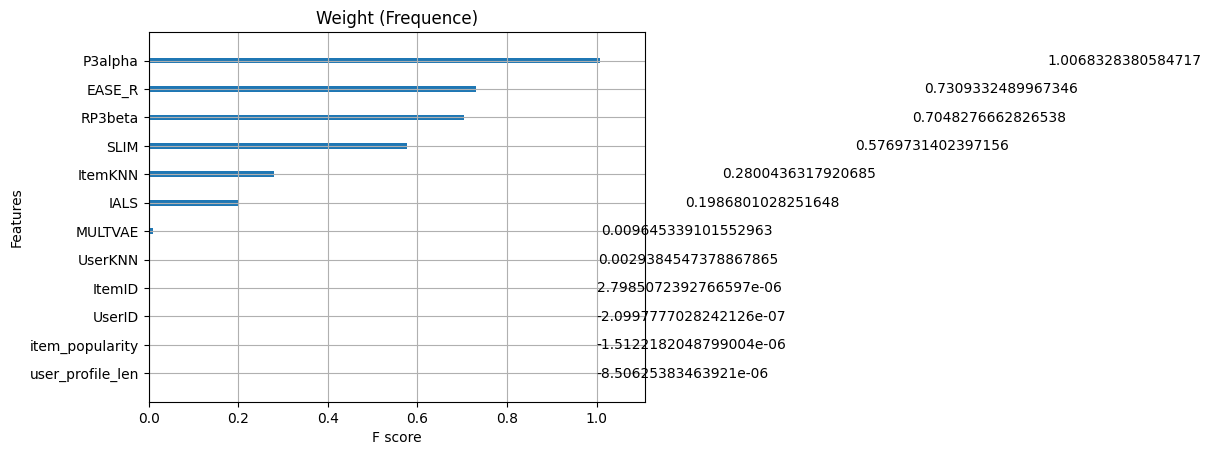

In [43]:
xgb = XgBoostEnsembler(URM_train_validation, URM_val=URM_test, recommenders=recommenders_t_val, recommenders_generate_data=rgd_t_val, internal_cutoff_xgboost=10)
params = {
    'objective': 'rank:pairwise',
    'n_estimators': 798,
    'learning_rate': 0.005475198763293265,
    'booster': 'gblinear',
    'reg_lambda': 1.5579294735565626e-08,
    'reg_alpha': 9.59987912675069e-07,
}
xgb.fit(xgb_ranker_params=params, prepare_training_df=True, plot=True)

In [ ]:
from Data_manager.UserUtils import getURM_all
from Hybrid import *
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender_OptimizerMask

URM_all = getURM_all()
hybrid_all = HybridRecommender(URM_all)
mv_all = MultVAERecommender_OptimizerMask(URM_all)
mv_all.load_model("slim_models/", "MultVAE_all_opt_300")
ials_all = IALSRecommender(URM_all)
ials_all.load_model("slim_models/", "IALS_all")
hybrid_all.MV_recommender = mv_all
hybrid_all.IALS_recommender = ials_all
recommenders_all = {"Hybrid": hybrid_all, 
                    "SLIM": SLIMElasticNetRecommender(URM_all),
                    "RP3beta": RP3betaRecommender(URM_all), 
                    "UserKNN": UserKNNCFRecommender(URM_all),
                    "ItemKNN": ItemKNNCFRecommender(URM_all), 
                    "EASE_R": EASE_R_Recommender(URM_all), 
                    #"PureSVD": PureSVDRecommender(URM_all), 
                    "P3alpha": P3alphaRecommender(URM_all), 
                    "MULTVAE": mv_all,
                    "IALS": ials_all,
                    }
recommenders_all["SLIM"].load_model("slim_models/", "slim_24")
recommenders_all["RP3beta"].fit(alpha=0.20026352123406477, beta=0.15999879728761354, topK=32)
recommenders_all["UserKNN"].fit(topK=469, shrink=38, similarity='asymmetric', normalize=True,
                                       feature_weighting='TF-IDF', asymmetric_alpha=0.40077406933762383)
recommenders_all["ItemKNN"].fit(topK=31, shrink=435, similarity='tversky', normalize=True,
                                       feature_weighting='BM25', tversky_alpha=0.17113169506422393, tversky_beta=0.5684024974085575)
recommenders_all["EASE_R"].load_model("slim_models/", "ease_all")
recommenders_all["P3alpha"].fit(topK=76, alpha=0.377201600381895, normalize_similarity=True)

recommenders_all["H_LI"] = LinearHybridRecommender(URM_all, [recommenders_all["SLIM"], recommenders_all["RP3beta"], recommenders_all["UserKNN"], recommenders_all["EASE_R"]])
recommenders_all["H_LI"].fit(alphas=[0.8857667100747117, 0.6379807942443021, 0.0690929184825888, 0.11953478623354052])
recommenders_all["H_HI"] = TwoScoresHybridRecommender(URM_all, recommenders_all["SLIM"], recommenders_all["RP3beta"])
recommenders_all["H_HI"].fit(alpha=0.6201320790279279)

In [83]:
recommenders_all.pop("H_LI")
recommenders_all.pop("H_HI")
recommenders_all.pop("Hybrid")

In [84]:
rgd_all = {
    "H_HI": TwoScoresHybridRecommender(URM_all, recommenders_all["SLIM"], recommenders_all["RP3beta"])
}
rgd_all["H_HI"].fit(alpha=0.6201320790279279)

In [85]:
xgb.recommenders = recommenders_all
xgb.recommenders_generate_data = rgd_all

In [86]:
import pandas as pd
URM_path = "data_train.csv"
URM_all_dataframe = pd.read_csv(filepath_or_buffer=URM_path,
                                sep=",",
                                # header=None,
                                dtype={0: int, 1: int, 2: int},
                                engine='python')

URM_all_dataframe.columns = ["UserID", "ItemID", "Interaction"]
import scipy.sparse as sps

mapped_id, original_id = pd.factorize(URM_all_dataframe["UserID"].unique())
user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(URM_all_dataframe["ItemID"].unique())
item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

In [ ]:
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Hybrid import *
from Recommenders.Neural.MultVAERecommender import MultVAERecommender_OptimizerMask
from Data_manager.UserUtils import *
import pandas as pd
import numpy as np

low_cutoff = 1
hi_cutoff = 3
# Load the CSV file
file_path = 'submission_hybrids_14231.csv'
df = pd.read_csv(file_path)

URM_all = getURM_all()
users_few_iterations = URM_all.sum(axis=1)  
users_few_iterations = np.array(users_few_iterations).squeeze()
# users_few_iterations = np.where(np.logical_and(users_few_iterations > low_cutoff, users_few_iterations < hi_cutoff))[0]
users_few_iterations = np.where(users_few_iterations > 13)[0]

slim = SLIMElasticNetRecommender(URM_all)
slim.load_model(folder_path="slim_models/", file_name="slim_24")
rp3 = RP3betaRecommender(URM_all)
rp3.fit(alpha=0.20026352123406477, beta=0.15999879728761354, topK=32)
itemknn = ItemKNNCFRecommender(URM_all)
itemknn.fit(topK=31, shrink=435, similarity='tversky', normalize=True,
                                       feature_weighting='BM25', tversky_alpha=0.17113169506422393, tversky_beta=0.5684024974085575)
userknn = UserKNNCFRecommender(URM_all)
userknn.fit(topK=469, shrink=38, similarity='asymmetric', normalize=True,
                                       feature_weighting='TF-IDF', asymmetric_alpha=0.40077406933762383)
knn = TwoScoresHybridRecommender(URM_all, userknn, itemknn)
knn.fit(alpha=0.022195783788315104)

ease = EASE_R_Recommender(URM_all)
ease.load_model(folder_path="slim_models/", file_name="ease_all")

# top = ScoresHybridRecommender(URM_all, slim, rp3, itemknn)
# top.fit(alpha=0.5072513954300486, beta=0.30902582824263064)


h = LinearHybridRecommender(URM_all, [slim, rp3, knn, ease])
h.fit(alphas=[0.8857667100747117, 0.6379807942443021, 0.0690929184825888, 0.11953478623354052])

mv = MultVAERecommender_OptimizerMask(URM_all)
mv.load_model(folder_path="slim_models/", file_name="MultVAE_all_opt_300")
# epochs = 350
# mv.fit(epochs=epochs, learning_rate=0.0002229220517428562, l2_reg=1.7199457884691567e-05, dropout=0.5397666797136971, total_anneal_steps=134713, anneal_cap=0.20025495518554443,batch_size=512,encoding_size=460,next_layer_size_multiplier=10,max_n_hidden_layers=4, max_parameters=3000000000.0)

ials = IALSRecommender(URM_all)
ials.load_model(folder_path="slim_models/", file_name="IALS_all")

# top = ScoresHybridRecommender(URM_all, knn, mv, ials)
# top.fit(alpha=0.7509279131476281, beta=0.028318614437090585)

# top = TwoScoresHybridRecommender(URM_all, slim, rp3)
# top.fit(alpha=0.6201320790279279)
# 
# top = LinearHybridRecommender(URM_all, [h, ials])
# top.fit(alphas=[0.9571032903283305, 0.04813884608839388])

top = xgb

item_index_to_original_id = item_original_ID_to_index.reset_index().set_index(0).to_numpy().reshape(-1)

update_dict = {}
for user_id in users_few_iterations:
    recommendations = [item_index_to_original_id[index] for index in top.recommend(user_id, cutoff=10)]
    recommendations = " ".join(str(x) for x in recommendations)
    user_original = user_original_ID_to_index.reset_index().set_index(0).to_numpy().reshape(-1)[user_id]
    update_dict[user_original] = recommendations

In [ ]:
# Update the item_list for the specified userIDs
for user_id, new_item_list in update_dict.items():
    df.loc[df['user_id'] == user_id, 'item_list'] = new_item_list

# Save the updated dataframe back to a CSV file
df.to_csv('updated_submission.csv', index=False)

In [ ]:
hybrid_all.fit()

In [3]:
dict_r_all = {
    "Hybrid": hybrid_all,
}

In [6]:
from Recommenders.XGBoostEnsemble import XgBoostEnsembler
main_recommender_all = "Hybrid"
XGBoostRecommender_all = XgBoostEnsembler(URM_all, URM_val=URM_test, recommenders=recommenders_all, recommenders_generate_data=dict_r_all, internal_cutoff_xgboost=30)

In [7]:
xgb_ranker_params = {
    "n_estimators": 50,
    "learning_rate": 1e-1,
    "reg_alpha": 1e-1,
    "reg_lambda": 1e-1,
    "max_depth": 20,
    "max_leaves": 0,
    "grow_policy": "depthwise",
    "objective": "rank:pairwise",
    "booster": "gbtree",
}
XGBoostRecommender_all.fit(xgb_ranker_params=xgb_ranker_params, plot=True)

Creating training dataframe...


AttributeError: 'HybridRecommender' object has no attribute 'hybrid_li'